# Hyperparameter Optimization
Evan Komp
DSMCER Guest Lecture 03.03.22
***

### Run below if using this notebook for the first time
*Make sure you have the proper environment activated!*

In [ ]:
!conda install -c conda-forge numpy scikit-learn optuna seaborn matplotlib -y

***
### Imports

In [ ]:
# data handling
import numpy as np
import sklearn.datasets

#plotting
import matplotlib.pyplot as plt
import matplotlib.animation

#models
import sklearn.tree

# hyperparameter optimization
import optuna
import sklearn.model_selection
import sklearn.preprocessing

***
### Warm up ... 

Name some hyperparameters you might have for a neural network.

## 1 - Why optimize hyperparameters?
### 1.1 Recap and Context

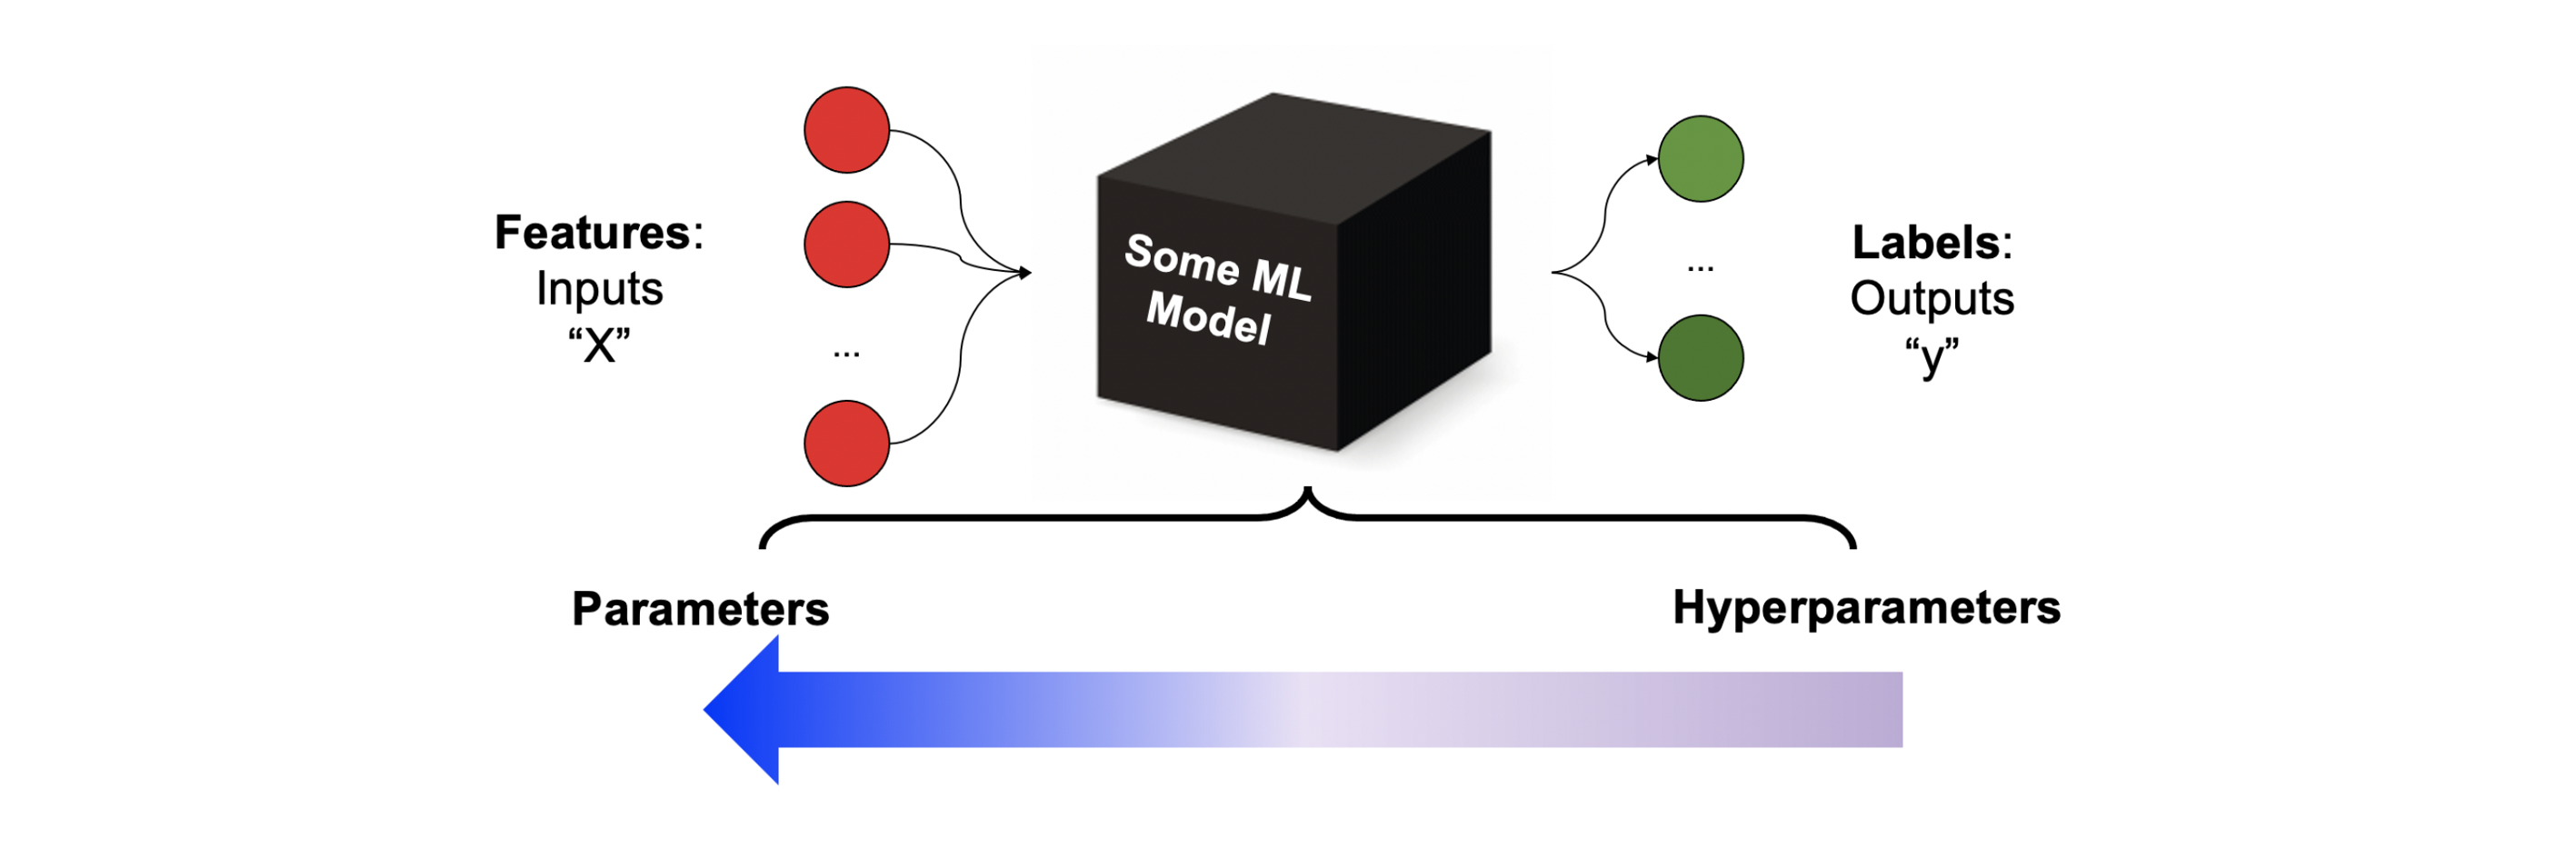

In math, we are trying to create a predictor

$$\hat{y} = f(X;\theta,\Omega)$$

for parameters $\theta$ and hyperparamers $\Omega$, such that

$$\textrm{loss}(y,\hat{y})$$

Is optimized.

Now let's say we have some hyperparameters $\Omega$, what is the process of *determining the best parameters* called? Eg.

$$\theta^* = \textrm{argmin}_\theta [\textrm{loss}(y,f(X;\theta,\Omega)))]$$

How would you do it for a linear regressor?

> ?

### 1.2 - Loss surface

Each model has a loss surface, and the best parameters $\theta^*$ are associated with *somewhere on this surface*. Here it is shown in the context of DNNs where $w$ are the neuron weights, $b$ are the neuron biases, and $\phi$ are some mapping of these to one dimension. Thus all model parameters $\theta$ are shown in two dimensions.

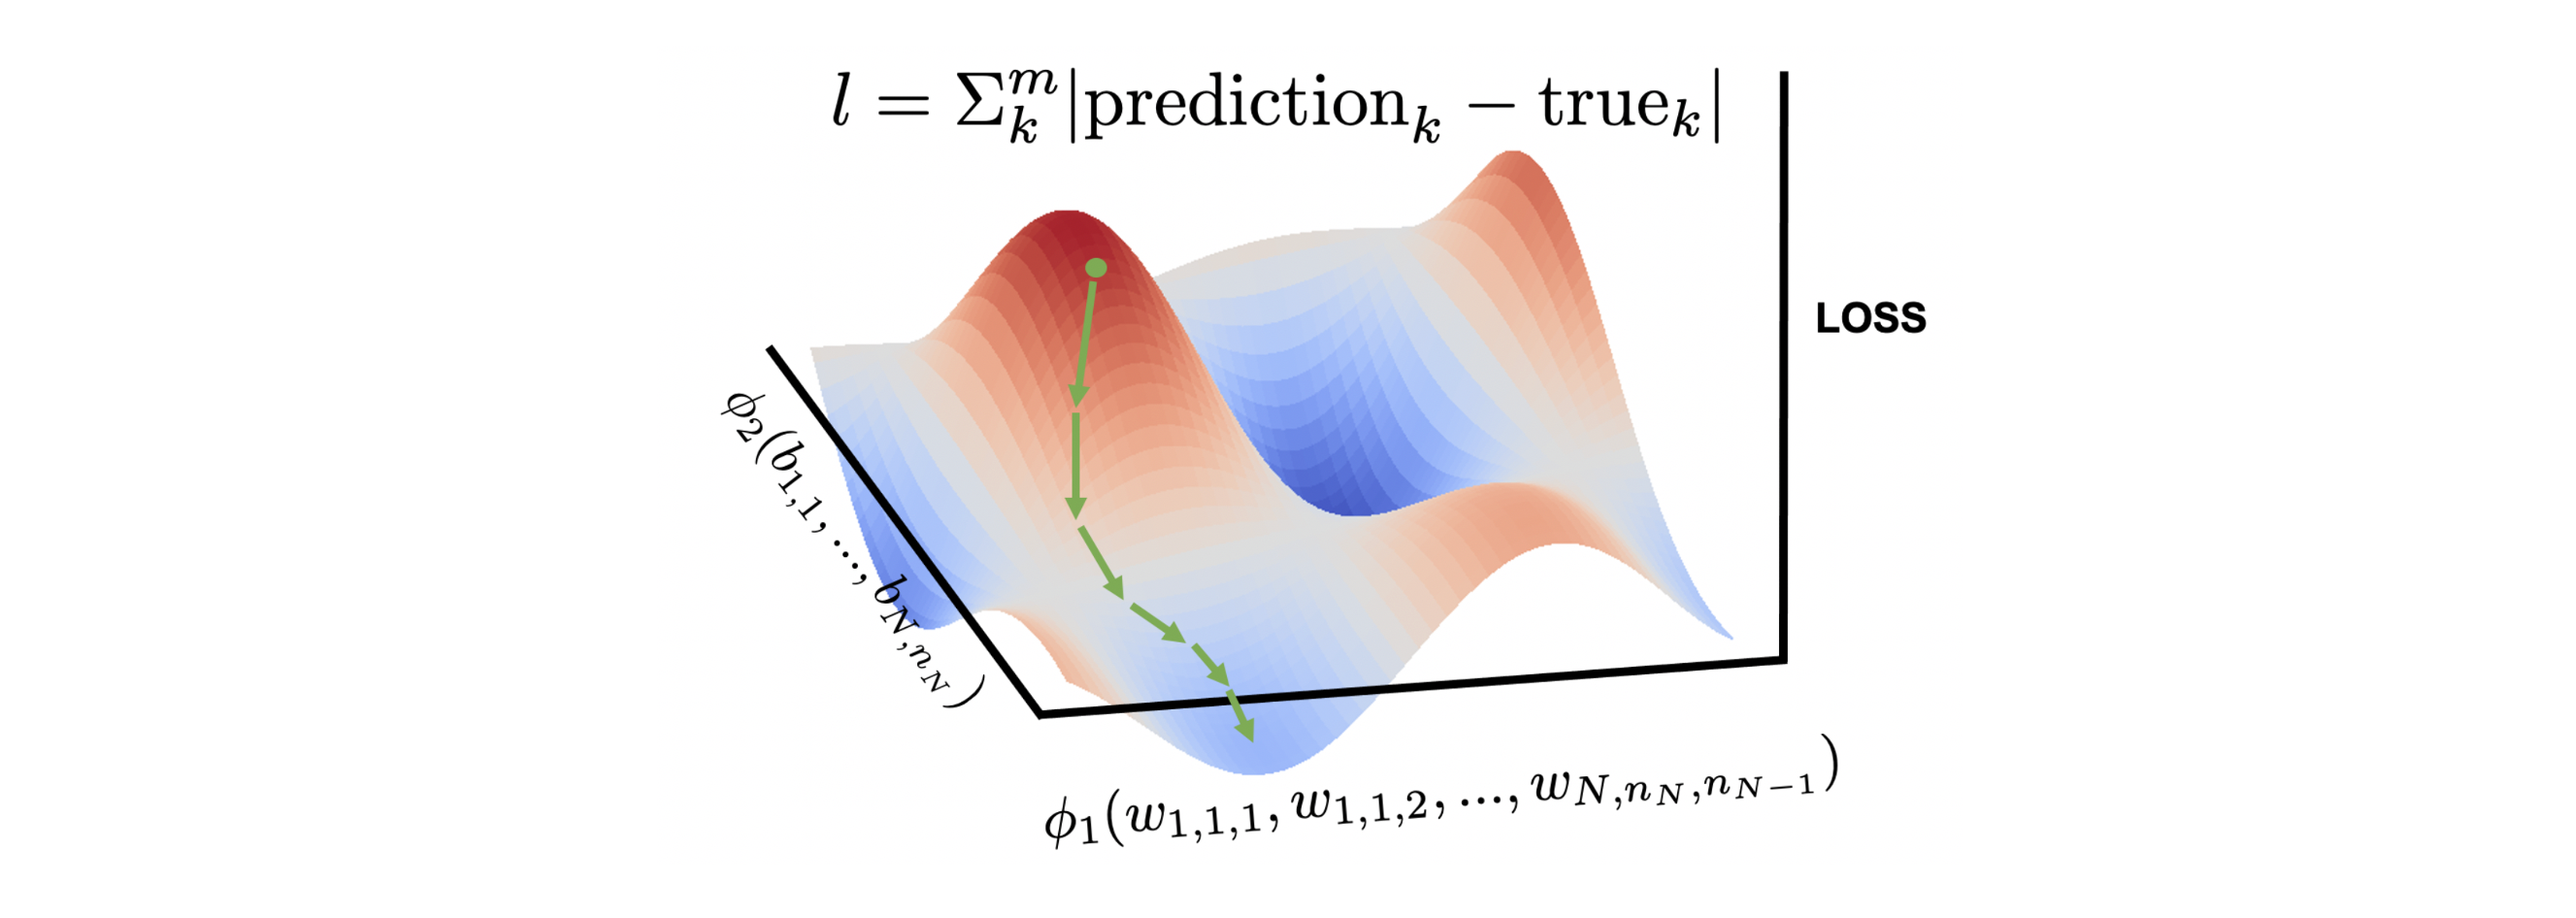

How many dimensions is this surface?

> ?

Our goal again is to find the lowest point on this surface. For neural nets, optimizers are used to *search* this surface for the optimal parameters $\theta^*$ (Green arrows above). Some examples of these are:
- Stochastic Gradient Descent
- RMS Prop
- Adam

We will not dive into the math of any of these, but I encourage you to recap the DNN lecture and explore these on your own time. At a high level, all of these are gradient descent models, eg. they change parameters by following the steepest path down this surface.

Critically what does this imply about the loss surface?

> ?

__Important takeaway__: This loss surface is *deterministic* for some set of data and some set of hyperparameters!

What does this imply about $\textrm{loss}(\hat{y},y)$ for some set of hyperparameters?

> ?

We can imagine a "hyperparameter loss surface":
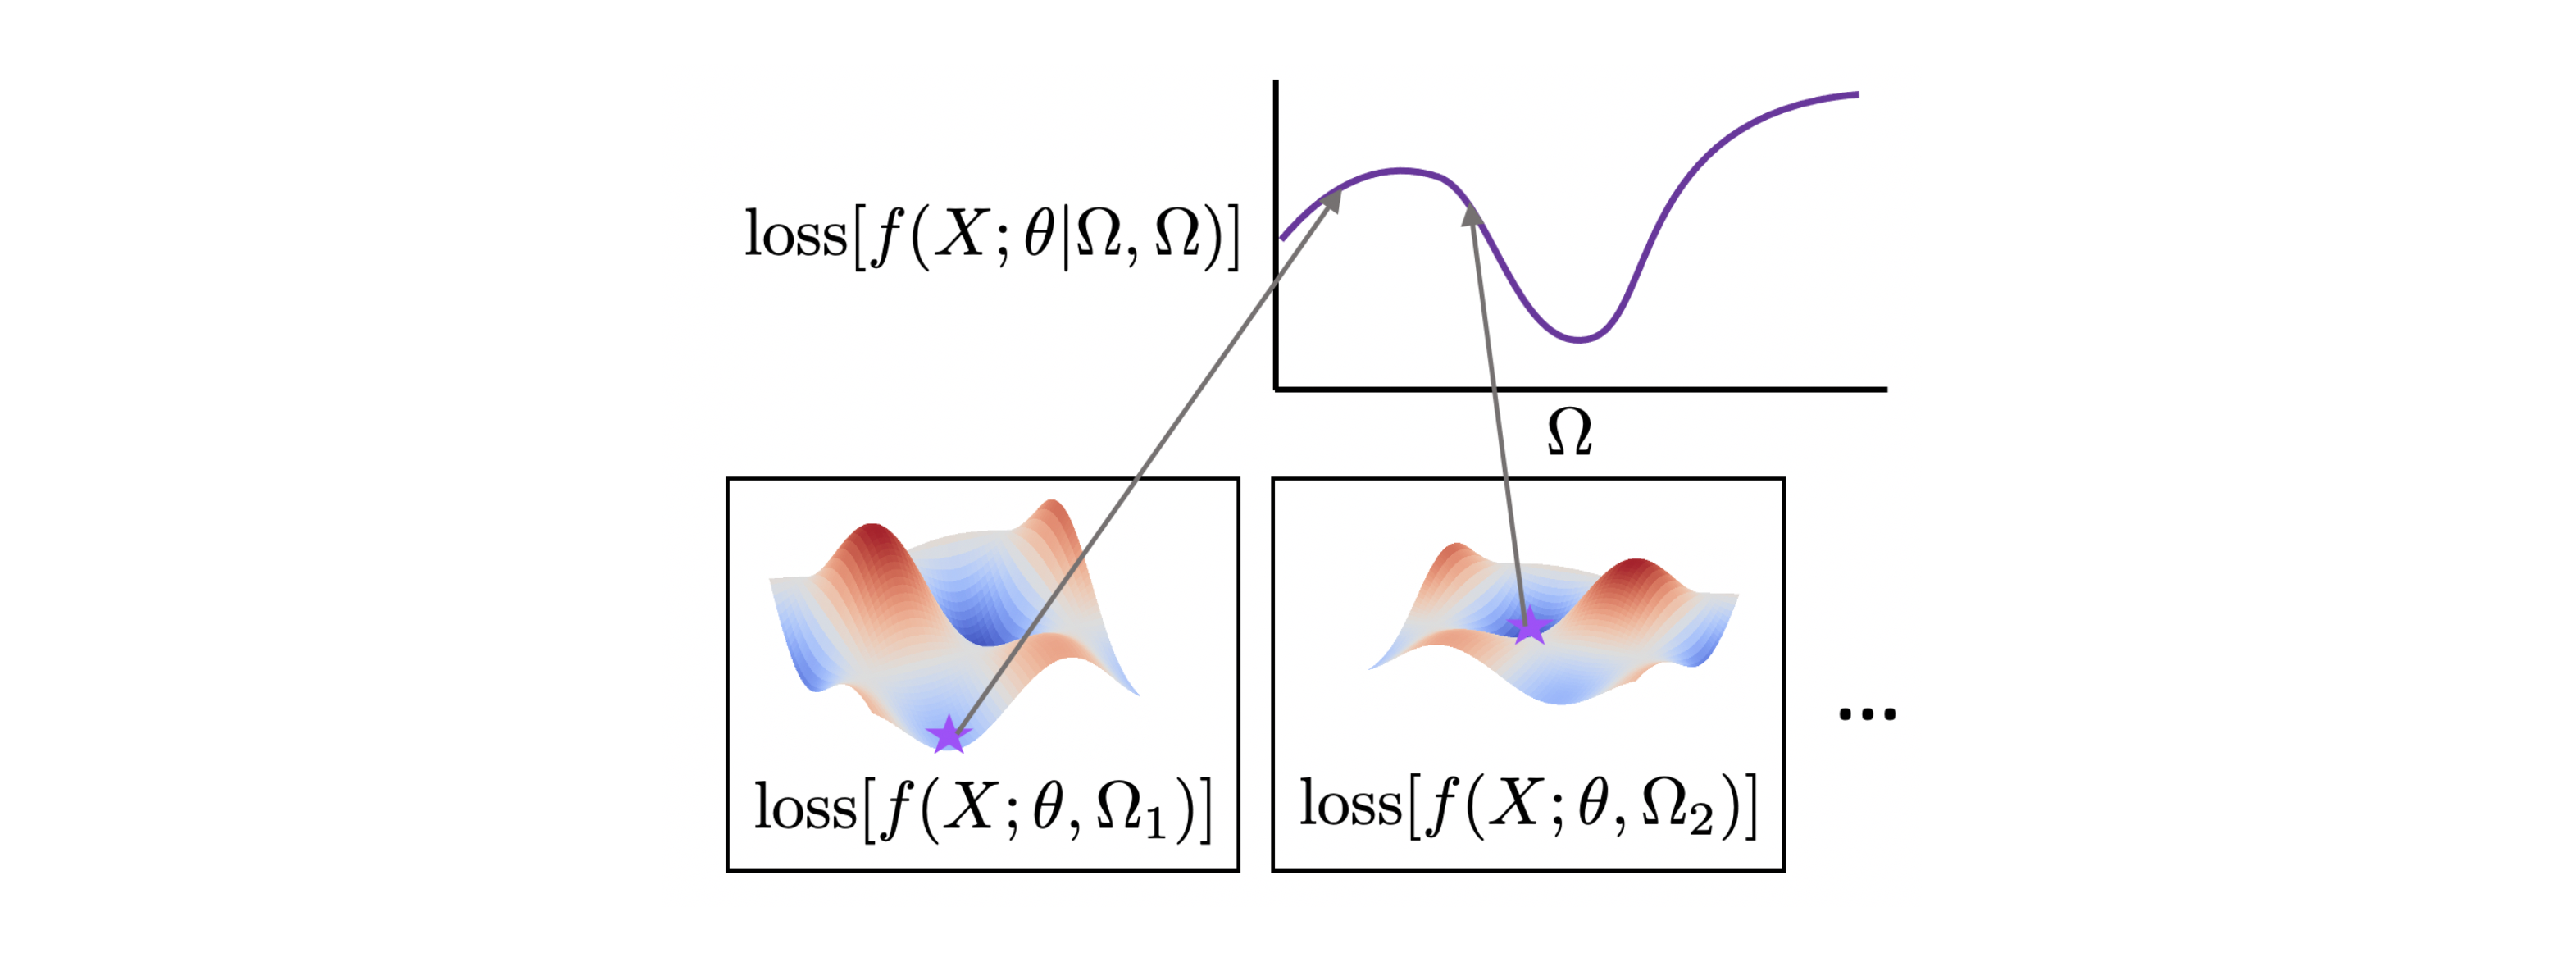

__Important takeaway__: Our model performance is dependent on both its parameters *and* its hyperparameters, so *we should optimize over hyperparameters* if we want to produce the best model! Note that for DNNs, while the loss surface itself and $\theta^*$ is deterministic, the trained parameters are not, because your optimizer finds a local minimum but is not guaranteed to find the global minumum.

What should we do to find the "best" set of hyperparameters $\Omega^*$?

> ?

***
## 2 - Preparing some data

What is our ultimate goal? To produce a model that...

> ?

__Important question__: What is rule number one of training and testing data? What is the justification of this rule?

> ?

We said we can evaluate the performance of a set of hyperparameters by its trained loss, but on what set of data? Is the loss of the trained model on the training set a good choice? On the testing set?

> ?

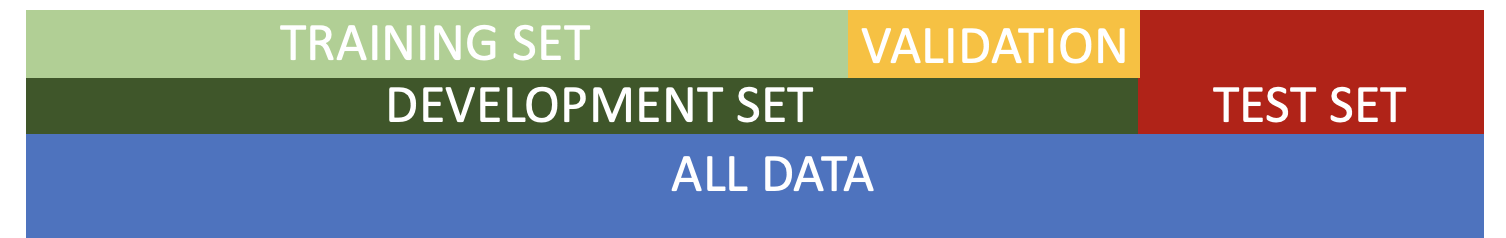

In [ ]:
# Load the data
X, y = sklearn.datasets.load_iris(return_X_y=True)

In [ ]:
# Split into development and testing set
X_dev, X_test, y_dev, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.20, random_state=42)

In [ ]:
# Split dev set into training and validation set
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X, y, test_size=0.20, random_state=42)

***
## 3 - How do we explore hyperparameter space to find the best value?

Demonstration task : For the `DecisionTreeClassifier` model, search for hyperparameters using validation accuracy as the metric.

- `max_depth` $\in \mathbb{N}(1,5)$ 
- `min_weight_fraction_leaf` $\in \mathbb{R}(0.0,0.5)$

### 3.1 - Method 1: Grid Search
*Brute Force*

Algorithm:

1. Discretize continuous hyperparameters on a grid, define hyperparameter options
2. For each combination of hyperparameters, train and evaluate validation performance
3. Output hyperparameter set with the best validation performance


On your own:

In [ ]:
def train_evaluate_hyperparameters(max_depth, min_weight_fraction_leaf):
    # create a model
    # train the model on the training set
    # evaluate the model on the validation set
    return score

In [ ]:
# create hyperparameter value options for each hyperparameter
max_depth_options = ##
min_weight_fraction_options = ##

# create a matrix to store results
validation_score = np.empty(
    (len(max_depth_options), len(min_weight_fraction_options))
)

# for each combination, record the validation score
for i, max_depth in enumerate(max_depth_options):
    for j, min_weight_fraction in enumerate(min_weight_fraction_options):
        validation_score[i,j] = train_evaluate_hyperparameters(max_depth, min_weight_fraction)

What does our surface look like?

In [ ]:
# Create a meshgrid plot of hyperparameter surface
MD, MWF = np.meshgrid(
    np.array(max_depth_options),
    min_weight_fraction_options)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.plot_wireframe(MD, MWF, validation_score.T, rstride=1, cstride=1)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Leaf Weight Fraction')
ax.set_zlabel('Validation Score')
plt.show()


The best hyperparameters:

In [ ]:
# get the hyperparameters that let to the best validation score
best_position = np.unravel_index(
    np.argmax(validation_score),
    validation_score.shape
)
print('Best max_depth: ', max_depth_options[best_position[0]])
print('Best min weight: ', min_weight_fraction_options[best_position[1]])

Do we have to do all of this coding? No... plenty of packages impliment this, including sklearn. It even lets you do cross validation really easily!

See sklearn's grid search [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Why would we want to do cross validation instead of a single validation set?

> ?

In [ ]:
# Define the grid of hyperparameter options. Same as we did, but store in a dictionary with
# hyperparameter names
param_grid = {
    'max_depth': max_depth_options,
    'min_weight_fraction_leaf': min_weight_fraction_options
}
# Create the grid search object
# Give it the model we want to use, the hyperparameters to search over
grid_search = sklearn.model_selection.GridSearchCV(
    sklearn.tree.DecisionTreeClassifier(),
    param_grid,
    cv=5
)
# execute the grid search
grid_search.fit(X_dev, y_dev)

print('Best hyperparameters: ', grid_search.best_params_)

Why did I use the dev set?

> ?

### 3.2 - Method 2: Random Search
*Brute Force*

Algorithm:

1. Define hyperparameter space
2. For a set of hyperparameters sampled from the space, train and evaluate validation performance
3. Output hyperparameter set with the best validation performance

See sklearn's random search [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

Let's say you do a grid search and a random search, each for 50 total combinations of hyperparameters, why might random search be desirable?


> ?

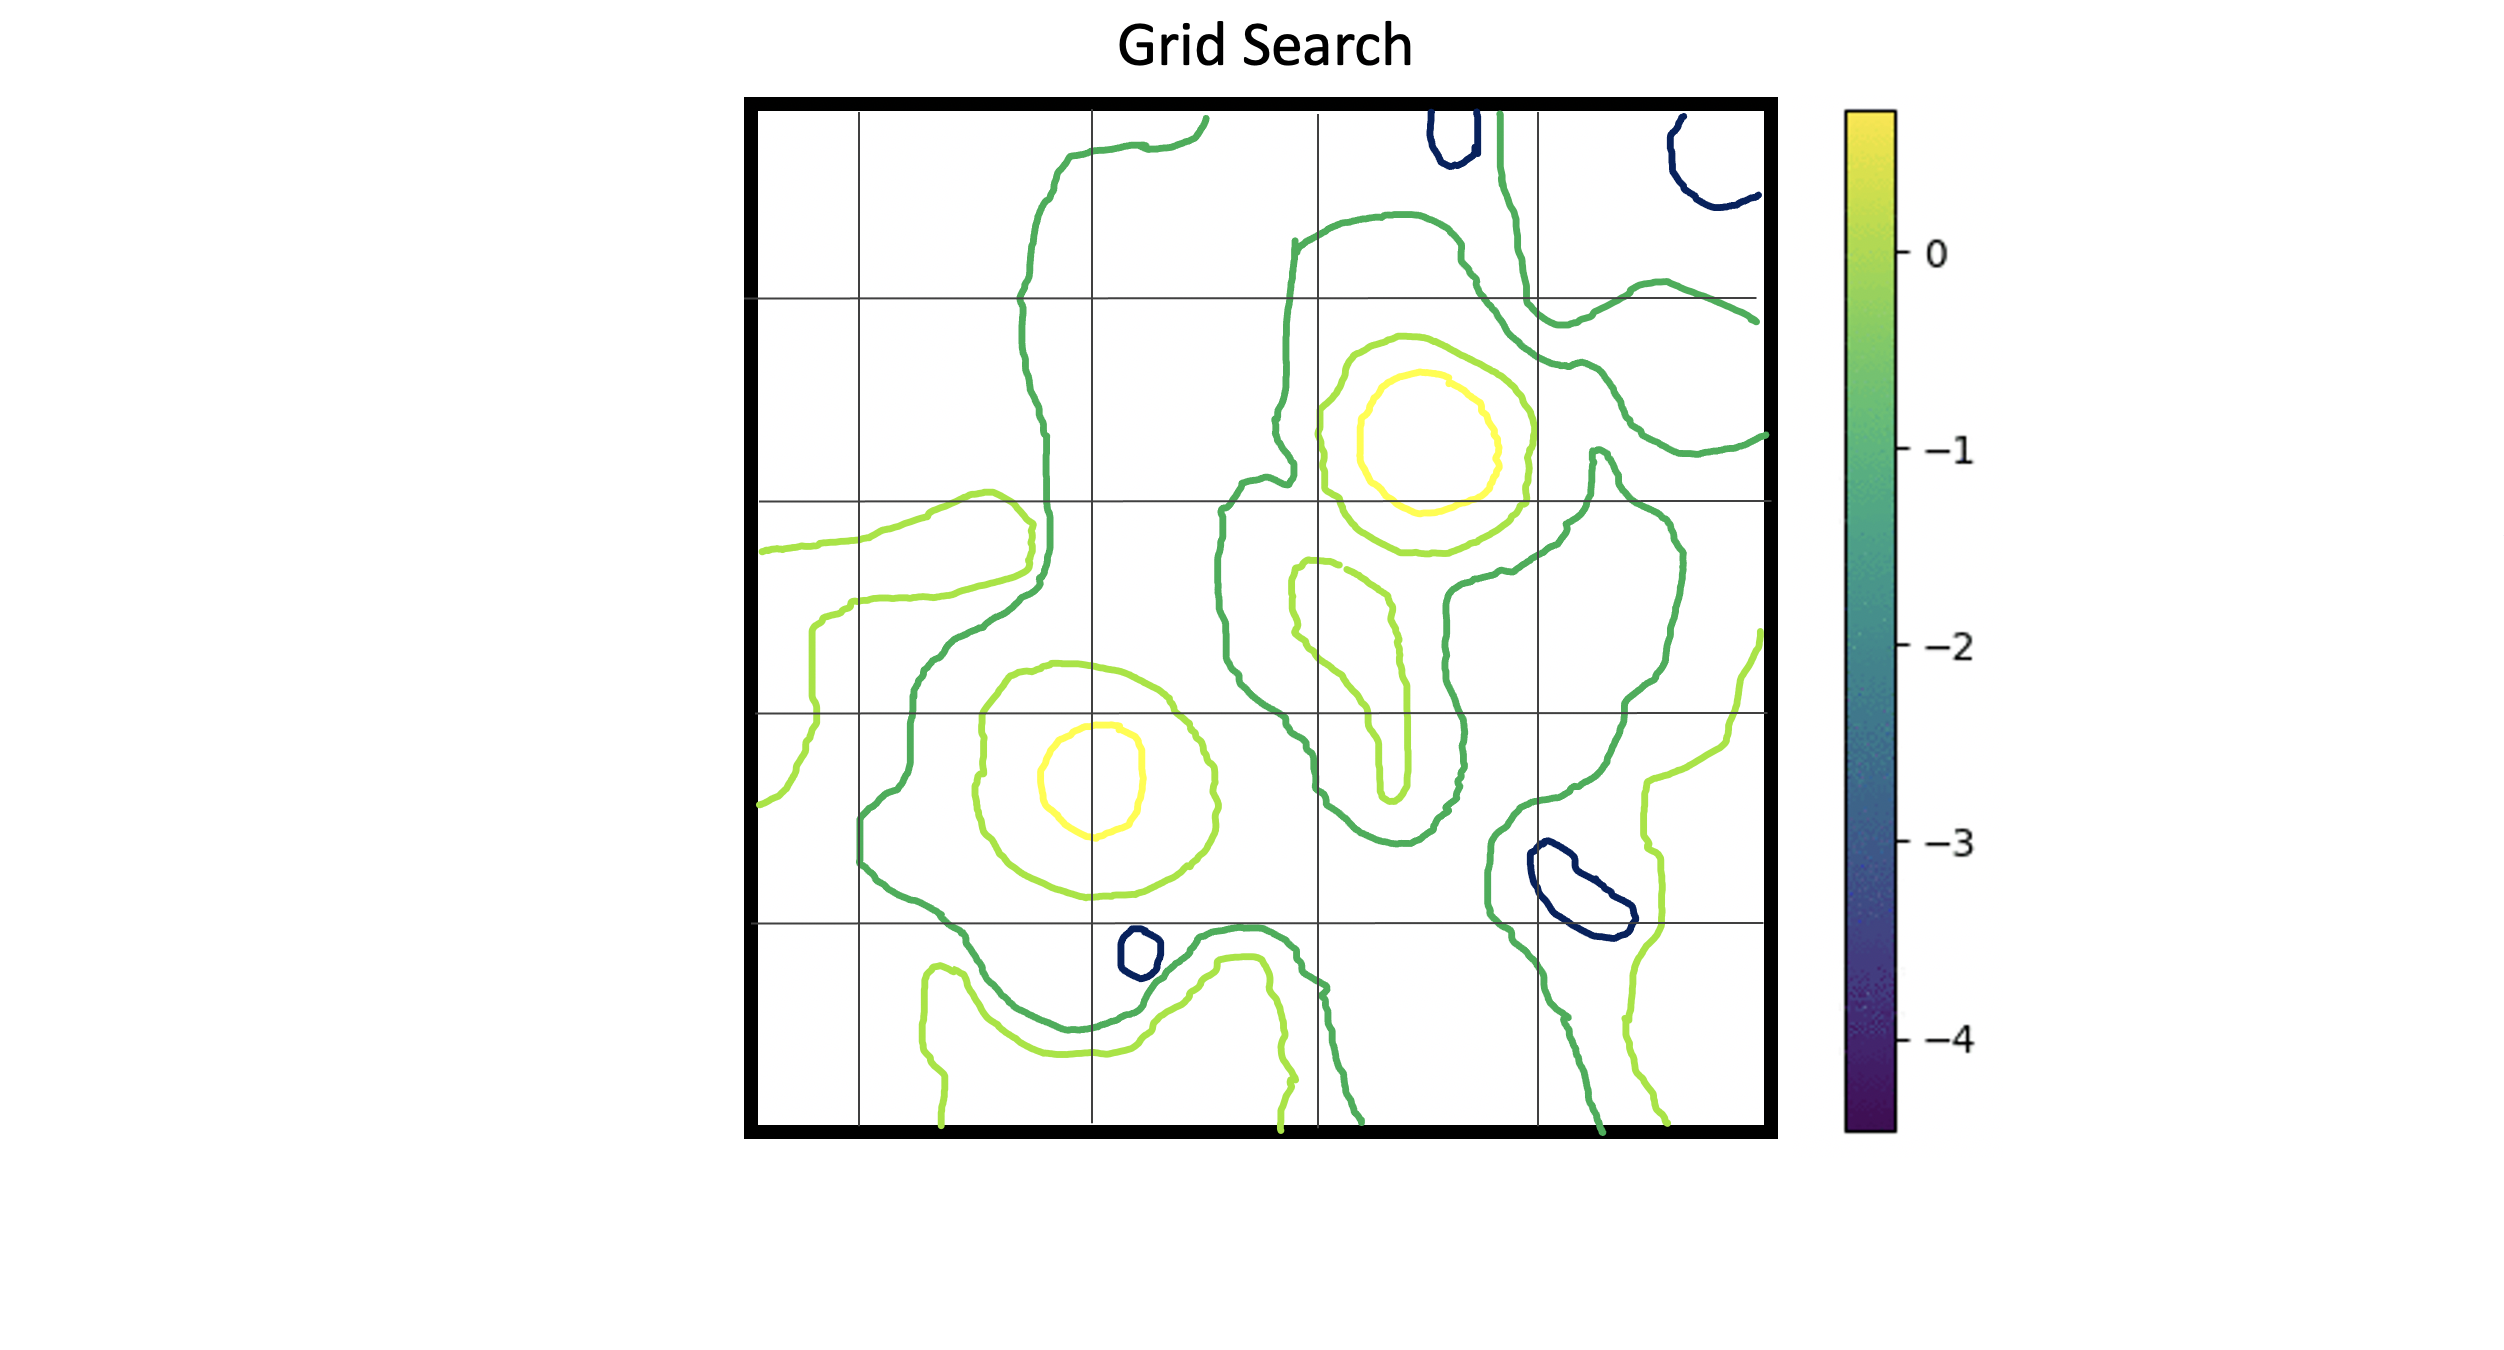
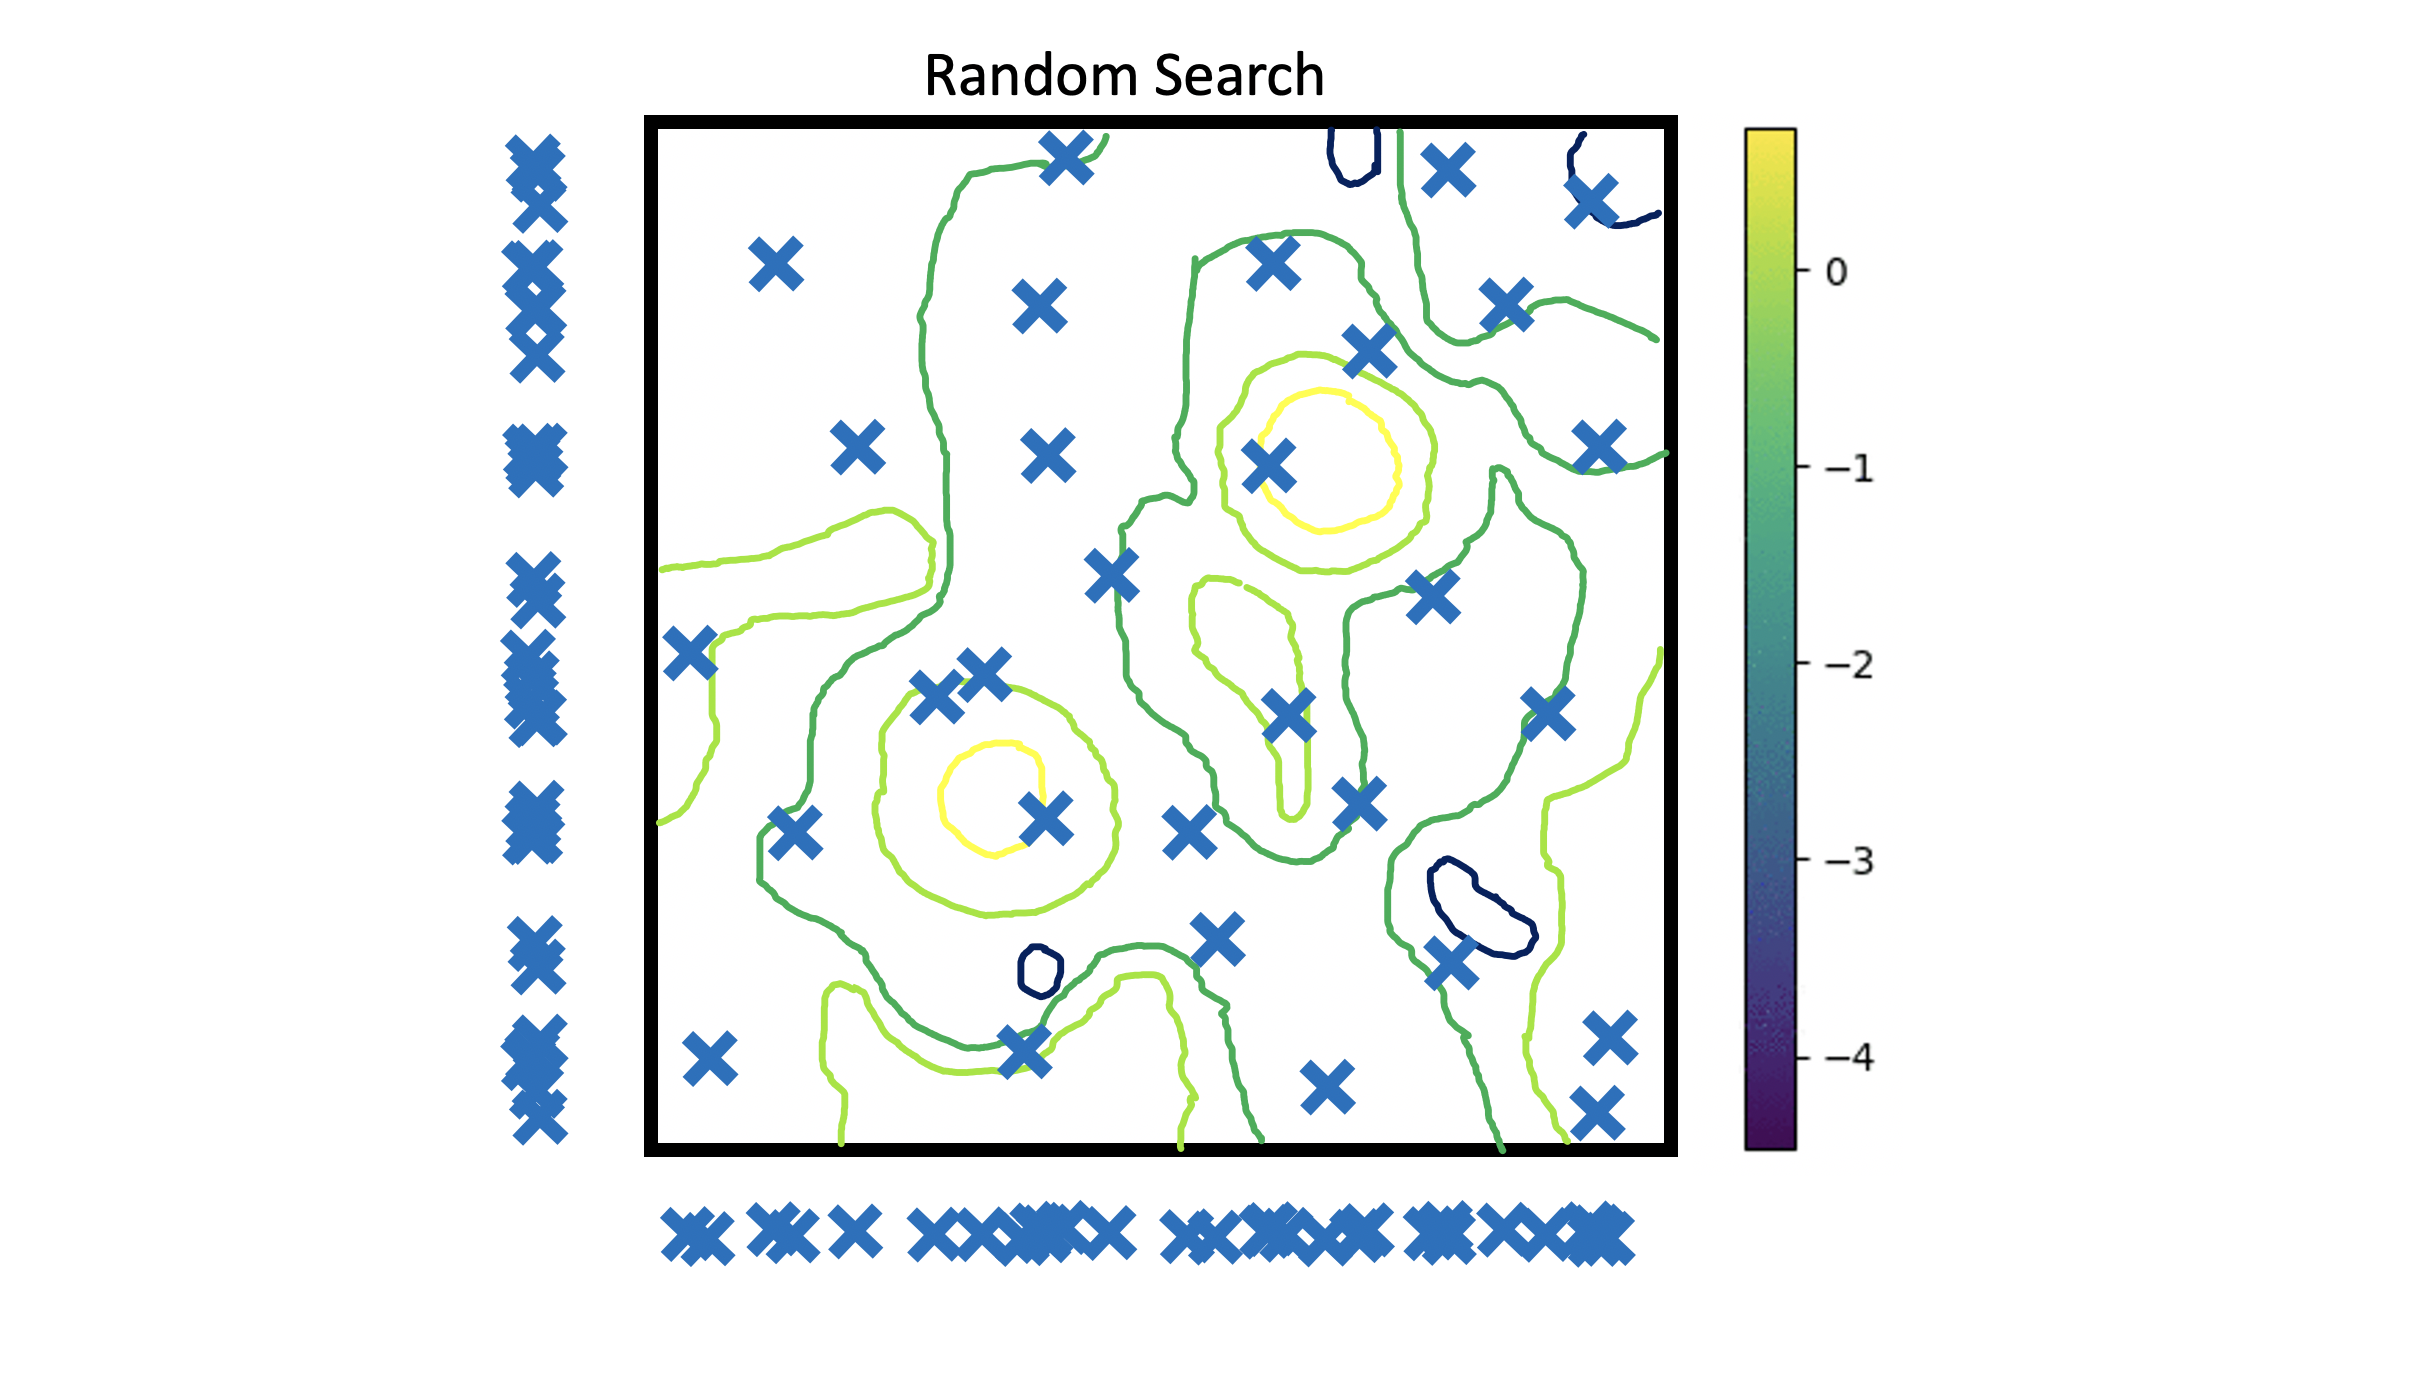

### 3.3 - Method 3: Tree Parzen Estimator (TPE)
*Adaptive*

Algorithm

1. Define hyperparameter ranges that the search is able to operate in
2. Select some hyperparameter values randomly and evaluate them
3. Seperate results into low performing and high performing hyperparameters by some quantile
4. Fit a kernel density estimate to each group
5. Sample the new values of hyperparameters to test from the ratio of good to bad densities
6. Evaluate this new value of hyperparameters, add it to the set of results
7. Repeat 3-6 until a desired validation score is reached or after a certain number of iterations

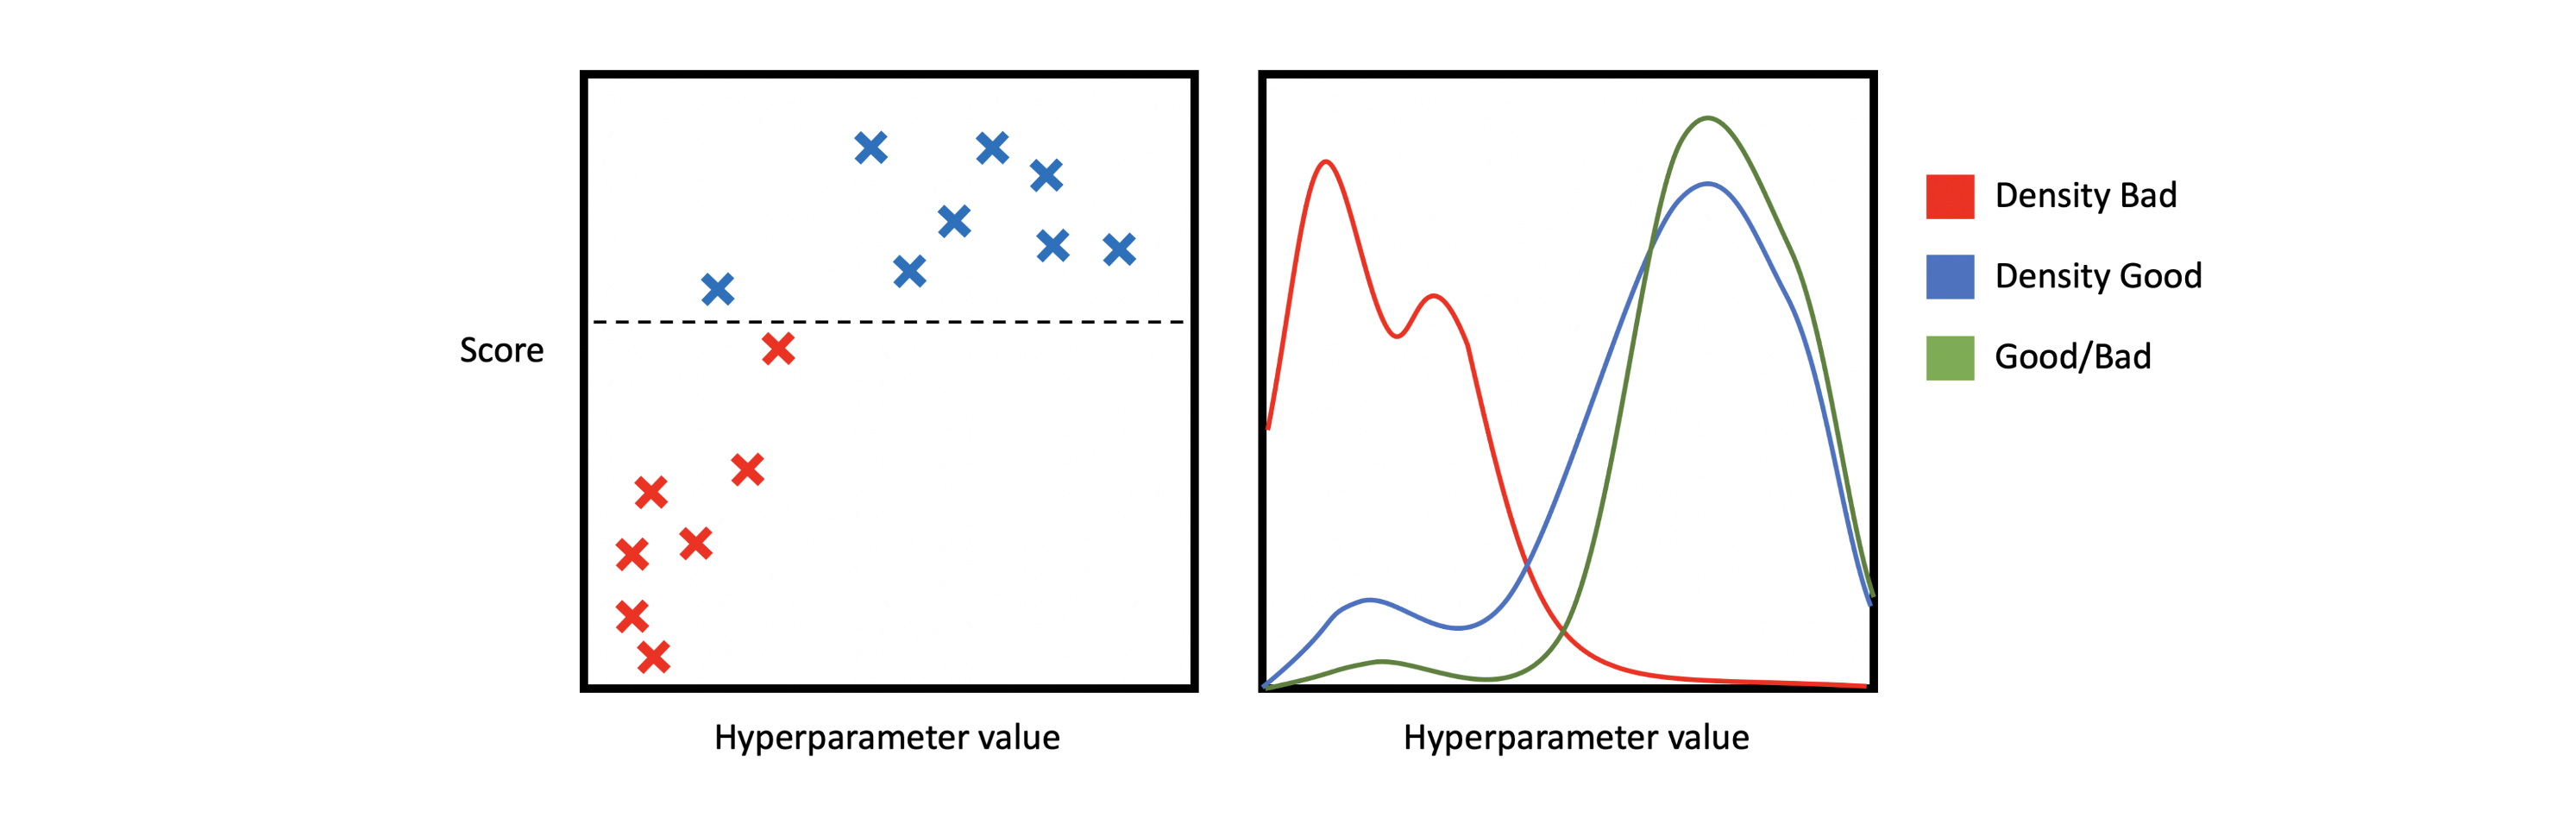

Optuna impliments TPE sampling. Optuna is very general and can be used for many optimization tasks. All we have to do is return an __objective__ function that takes in a set of hyperparameters, and returns a score to minimize or maximize.

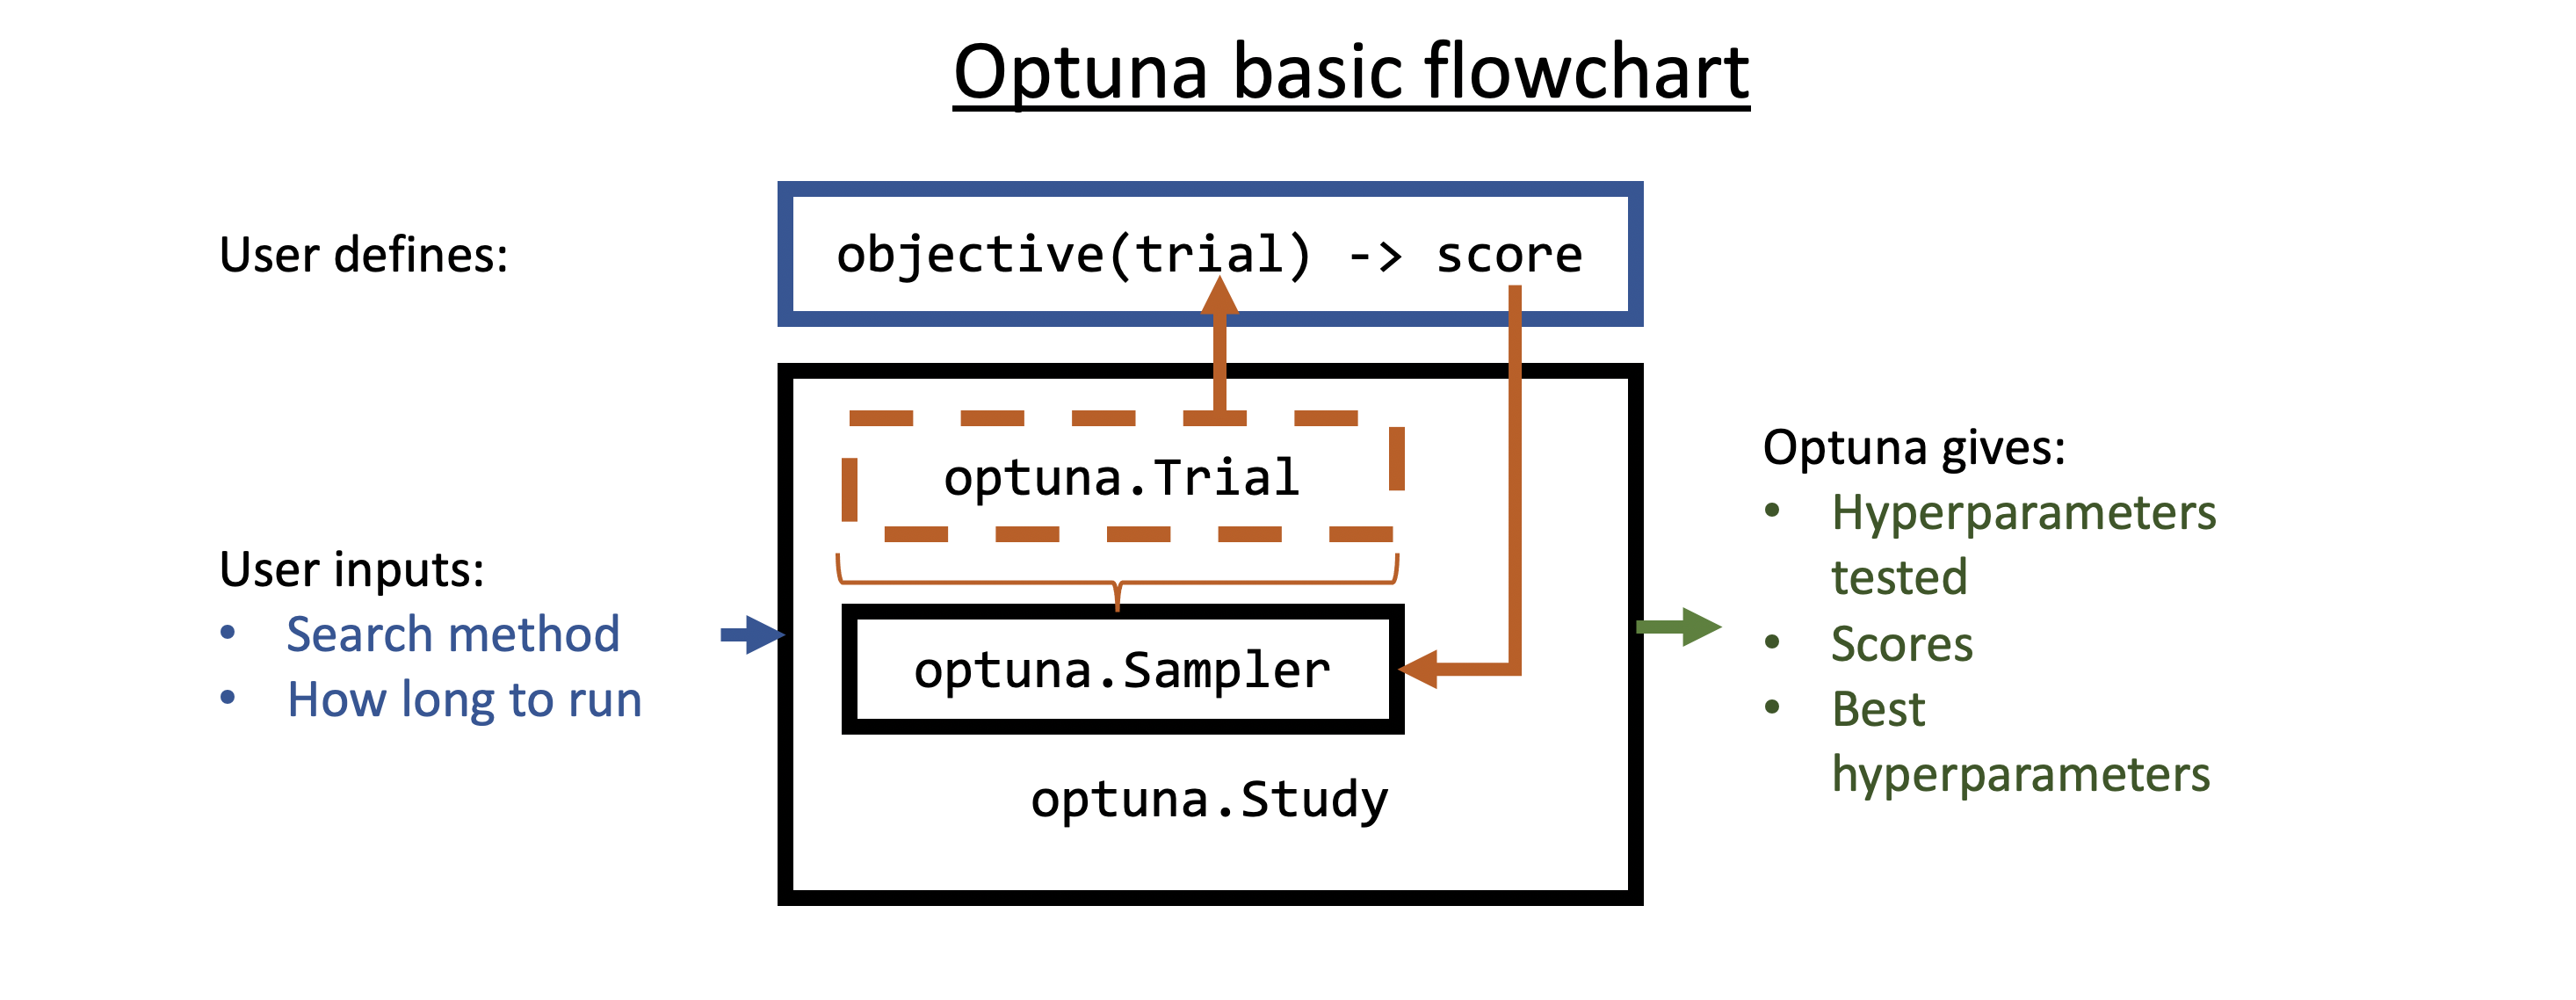

On your own time, check out these chunks of Optuna:
- [Study](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study)
- [Sampler](https://optuna.readthedocs.io/en/stable/reference/samplers.html)
- [Trial](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial)


Let's demonstrate this on a toy analytical surface in two dimensions:

In [ ]:
# Two dimensional gaussian function of x and y
def two_d_gaussian(x, y, mean=(0,0), std=(1,1)):
    return np.exp(-((x-mean[0])**2/(2*std[0]**2) +(y-mean[1])**2/(2*std[1]**2)))

# analystical suface that is a weighted sum of two 2d gaussians
def analytical_score(x,y):
    return (two_d_gaussian(x, y, mean=(.2,.1), std=(.3,.6)) + 1.2*two_d_gaussian(x, y, mean=(.8,.6), std=(.2,.1)))

In [ ]:
X, Y = np.meshgrid(
    np.linspace(0,1,200),
    np.linspace(0,1,200)
)
Z = analytical_score(X,Y)

fig, ax = plt.subplots(figsize=(7,7))
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Analytical score')
ax.set_xlabel('x')
ax.set_ylabel('y')

Let's watch TPE find the best value of $x$ and $y$:

In [ ]:
# define our objective that takes in a trial, picks some hyperparameters for that trial
# evaluates the hyperparameters
# then returns the value to optimize
def objective(trial):
    # define hyperparameter space
    x = trial.suggest_float("x", 0.0, 1.0)
    y = trial.suggest_float("y", 0.0, 1.0)
    
    # get the score for the hyperparameters chosen
    score = analytical_score(x,y)
    
    return score

# Create a study with the tep sampler
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
# run the study.
# this uses TPE to try different hyperparameters (in this case x and y)
# and searches for the best ones
study.optimize(objective, n_trials=50)
# get the results as dataframe
results = study.trials_dataframe()

In [ ]:
results

In [ ]:
# exact same surface plot as before
X, Y = np.meshgrid(
    np.linspace(0,1,200),
    np.linspace(0,1,200)
)
Z = analytical_score(X,Y)

fig, ax = plt.subplots(figsize=(7,7))
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Analytical score')
ax.set_xlabel('x')
ax.set_ylabel('y')

# animate the trials tested as points on that surface
def animate(i):
    ax.scatter(results.loc[i, 'params_x'], results.loc[i, 'params_y'], color='k')
    
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=range(1, len(results)), interval=1000, repeat=False)
anim.save('animation.gif', writer='pillow', fps=3)

Optuna has a number of ways to select hyperparameters:
- `suggest_uniform` for continuous hyperparameters uniformly
- `suggest_loguniform` for continuous hyperparameters uniformly on the log scale
- `suggest_discrete_uniform` for continuous hyperparameters that should be sampled from a grid
- `suggest_categorical` for discrete hyperparameters
- `suggest_int` for integer hyperparameters

Impliment a TPE search for the the `DecisionTreeClassifier`, search for

- `max_depth` $\in \mathbb{N}(1,5)$ 
- `min_weight_fraction_leaf` $\in \mathbb{R}(0.0,0.5)$

Use validation accuracy again as a metric. Run it for 50 trials. What are the best parameters identified this way?

In [ ]:
def objective(trial):
    # define hyperparameter space
    
    # get the score for the hyperparameters chosen
    
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=50)
print('Best params: ', study.best_params)

One solution

In [ ]:
def objective(trial):
    # define hyperparameter space
    max_depth = trial.suggest_int('max_depth', 1, 5)
    min_weight_fraction_leaf = trial.suggest_uniform(
        'min_weight_fraction_leaf', 0.0, 0.5)
    
    # get the score for the hyperparameters chosen
    score = train_evaluate_hyperparameters(max_depth, min_weight_fraction_leaf)
    return score

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='maximize')
study.optimize(objective, n_trials=50)
print('Best params: ', study.best_params)

In the same number of trials as Grid Search, we found a more fine tuned value of our continuous hyperparameter `min_weight_fraction_leaf` which in grid search could only take specific values on a grid!

## 4 - Additional thoughts and tools

If you are interested, reach out.

1. Using an adaptive search like TPE is most important when your objective function takes a long time to evaluate. For example, if you have a large dataset and a very deep neural network, training an evaluation can take on the order of hours, so finding the best parameters with as few trials as possible is important.
2. Optuna Grid, Random, TPE and other adaptive algorithms implemented. See Samplers above.
3. You can use "pruning" to reduce your trial time. Optuna supports this. This is where you evaluate your tenative performance periodically before your model is fully trained. Assuming that a model performing poorly eg. halfway through training won't suddenly become the best, you can stop training and move on. Some criteria is used eg "If a model at 10 epochs is performing in the bottom 25% of models at 10 epochs, cut it." See [here](https://optuna.readthedocs.io/en/v1.0.0/tutorial/pruning.html).
4. You can run hyperparameter searches in parallel. Instead of trying one set of hyperparameters and then moving on, try a number at the same time. For example, with 4 cores on your CPU you can do 4 trials simultaneously. See [here](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/004_distributed.html).